# CSCE633 Machine Learning - HW2

## Programming Questions

### Part A - Classification Tree (50 points)

#### Import all the libraries

In [1]:
import os
import json
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve

#### A-1 Data Processing and EDA

1. There are 2 data splits for this homework, data train and data test. The data test doesn’t have ground truth labels, you need to use the trained model to do inference on it. For validation, you can split the training data to train and validation sets. Read the data. (Try read csv() function in pandas library)

Put the data_train.csv and data_test.csv under the root directory or inside a data folder.

In [2]:
train_data_path = "./data/data_train-1.csv"
test_data_path = "./data/data_test-1.csv"
out_path = "./Mu-Ruei_Tseng_preds.csv"

if not os.path.exists(train_data_path):
    train_data_path = "./data_train.csv"

if not os.path.exists(test_data_path):
    test_data_path = "./data_test.csv"
    
assert os.path.exists(train_data_path) and os.path.exists(test_data_path),"Data not found." 

print("Reading train data from: {}".format(train_data_path))
print("Reading test data from: {}".format(test_data_path))


Reading train data from: ./data/data_train-1.csv
Reading test data from: ./data/data_test-1.csv


2. Print the training data. How does the data look like? Add a short description about the data. (You may use head() function in pandas library)

In [3]:
train_df = pd.read_csv(train_data_path, index_col=0)
test_df = pd.read_csv(test_data_path, index_col=0)
num_rows = 5 # 
print("First {} rows of the training data: ".format(num_rows))
print(train_df.head(n=num_rows))

print("=================================================================================")

print("First {} rows of the test data: ".format(num_rows))
print(test_df.head(n=num_rows))


First 5 rows of the training data: 
    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001518   Male     Yes          1  Graduate            No   
1  LP002734   Male     Yes          0  Graduate            No   
2  LP002697   Male      No          0  Graduate            No   
3  LP002455   Male     Yes          2  Graduate            No   
4  LP001732   Male     Yes          2  Graduate           NaN   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             1538             1425.0        30.0             360.0   
1             6133             3906.0       324.0             360.0   
2             4680             2087.0         NaN             360.0   
3             3859                0.0        96.0             360.0   
4             5000                0.0        72.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Urban           Y  
2       

Write-Up: The training data comprises 13 columns, with 'Loan_Status' as the target variable we aim to predict and 'Loan_ID' serving as the data identifier. The remaining columns should be utilized as features for training. Additionally, it can be observed that some features are categorical, while others are continuous.

3. Return the shape of the data. Shape means the dimensions of the data. (In Python, pandas dataframe instances have a variable shape)

In [4]:
print("The shape of the training dataframe: {}".format(train_df.shape))
print("=================================================================================")
print("The shape of the testing dataframe: {}".format(test_df.shape))

The shape of the training dataframe: (491, 13)
The shape of the testing dataframe: (123, 12)


4. Does the data have any missing values? How many are missing? Process the data to remove these missing values. You can drop the corresponding rows or apply imputation. (In pandas, check out isnull() and isnull().sum())

In [5]:
def check_missing_values(df):
    missing_values = [] # stores the row that contains missing(null) values
    total_missing_values = 0
    for index, row in df.iterrows():
        if row.isnull().any():
            missing_values.append(index)
        total_missing_values += row.isnull().sum()
    number_of_missing_values = len(missing_values)
    has_missing_values = True if number_of_missing_values > 0 else False
    
    return has_missing_values, number_of_missing_values, total_missing_values

print("Checking for missing values in the training data...")
has_missing_values, number_of_missing_values, total_missing_values = check_missing_values(train_df)
print("Does the data have any missing values? Ans:{}".format(has_missing_values))
print("How many rows have missing values? Ans:{}".format(number_of_missing_values))
print("Total number of missing values: {}".format(total_missing_values))
print("=================================================================================")

print("Checking missing values in the test data...")
has_missing_values, number_of_missing_values, total_missing_values = check_missing_values(test_df)
print("Does the data have any missing values? Ans:{}".format(has_missing_values))
print("How many rows have missing values? Ans:{}".format(number_of_missing_values))
print("Total number of missing values: {}".format(total_missing_values))
print("=================================================================================")

Checking for missing values in the training data...
Does the data have any missing values? Ans:True
How many rows have missing values? Ans:118
Total number of missing values: 129
Checking missing values in the test data...
Does the data have any missing values? Ans:True
How many rows have missing values? Ans:16
Total number of missing values: 20


If a data contains NaN values, we will drop that row.

In [6]:
train_df = train_df.dropna()
print("The shape of the training dataframe after dropping rows with any missing data: {}".format(train_df.shape))

test_df = test_df.dropna()
print("The shape of the test dataframe after dropping rows with any missing data: {}".format(test_df.shape))

The shape of the training dataframe after dropping rows with any missing data: (373, 13)
The shape of the test dataframe after dropping rows with any missing data: (107, 12)


5. Extract the features and the label from the data. Our label is Loan_Status in this case.

In [7]:
label_column = "Loan_Status"
feature_columns = [col for col in train_df.columns if col != label_column and col != "Loan_ID"]

features = train_df[feature_columns]
label = train_df[label_column]
num_features = features.shape[1]

print("Features: {}".format(features.shape))
print(features.head(n=num_rows))
print("=================================================================================")
print("Label: {}".format(label.shape))
print(label.head(n=num_rows))

Features: (373, 11)
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male     Yes          1      Graduate            No             1538   
1   Male     Yes          0      Graduate            No             6133   
3   Male     Yes          2      Graduate            No             3859   
5   Male      No          0  Not Graduate           Yes             2583   
6   Male     Yes          0      Graduate            No             5829   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0             1425.0        30.0             360.0             1.0   
1             3906.0       324.0             360.0             1.0   
3                0.0        96.0             360.0             1.0   
5             2167.0       104.0             360.0             1.0   
6                0.0       138.0             360.0             1.0   

  Property_Area  
0         Urban  
1         Urban  
3     Semiurban  
5         Rural  
6         Ru

5. Plot the histograms of all the variables in the data.

In [8]:
def isCategorical(column_name):
    categorical_features = [
        'Loan_ID',
        'Gender',
        'Married',
        'Dependents',
        'Education',
        'Self_Employed',
        'Property_Area',
        'Loan_Status'
    ]
    return column_name in categorical_features

    
def plot_histogram(features):
    num_features = features.shape[1]
    feature_columns = features.columns
    
    plot_columns = 4
    plot_rows = num_features // plot_columns + (num_features % plot_columns > 0)
    fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(num_features):
        ax = axes[i // plot_columns, i % plot_columns]
        is_categorical = isCategorical(feature_columns[i])
        
        if is_categorical:
            # For categorical data, use value_counts to get a bar chart
            category_counts = features.iloc[:, i].value_counts()
            ax.bar(category_counts.index, category_counts, width=0.5, edgecolor='black')
        else:
            # For numerical data, automatically determine the bin size
            bins = min(int(np.sqrt(features.iloc[:, i].shape[0])), 50)
            ax.hist(features.iloc[:, i], bins=bins, edgecolor='black')

        ax.set_title(feature_columns[i])

    # remove the empty subplots if the number of features is not a multiple of `plot_columns`
    for i in range(num_features, plot_rows * plot_columns):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle("Histogram of the features", fontsize=16, y=1.02)
    fig.legend(["Histogram"], loc="lower right")

    plt.tight_layout()
    plt.show()

    return

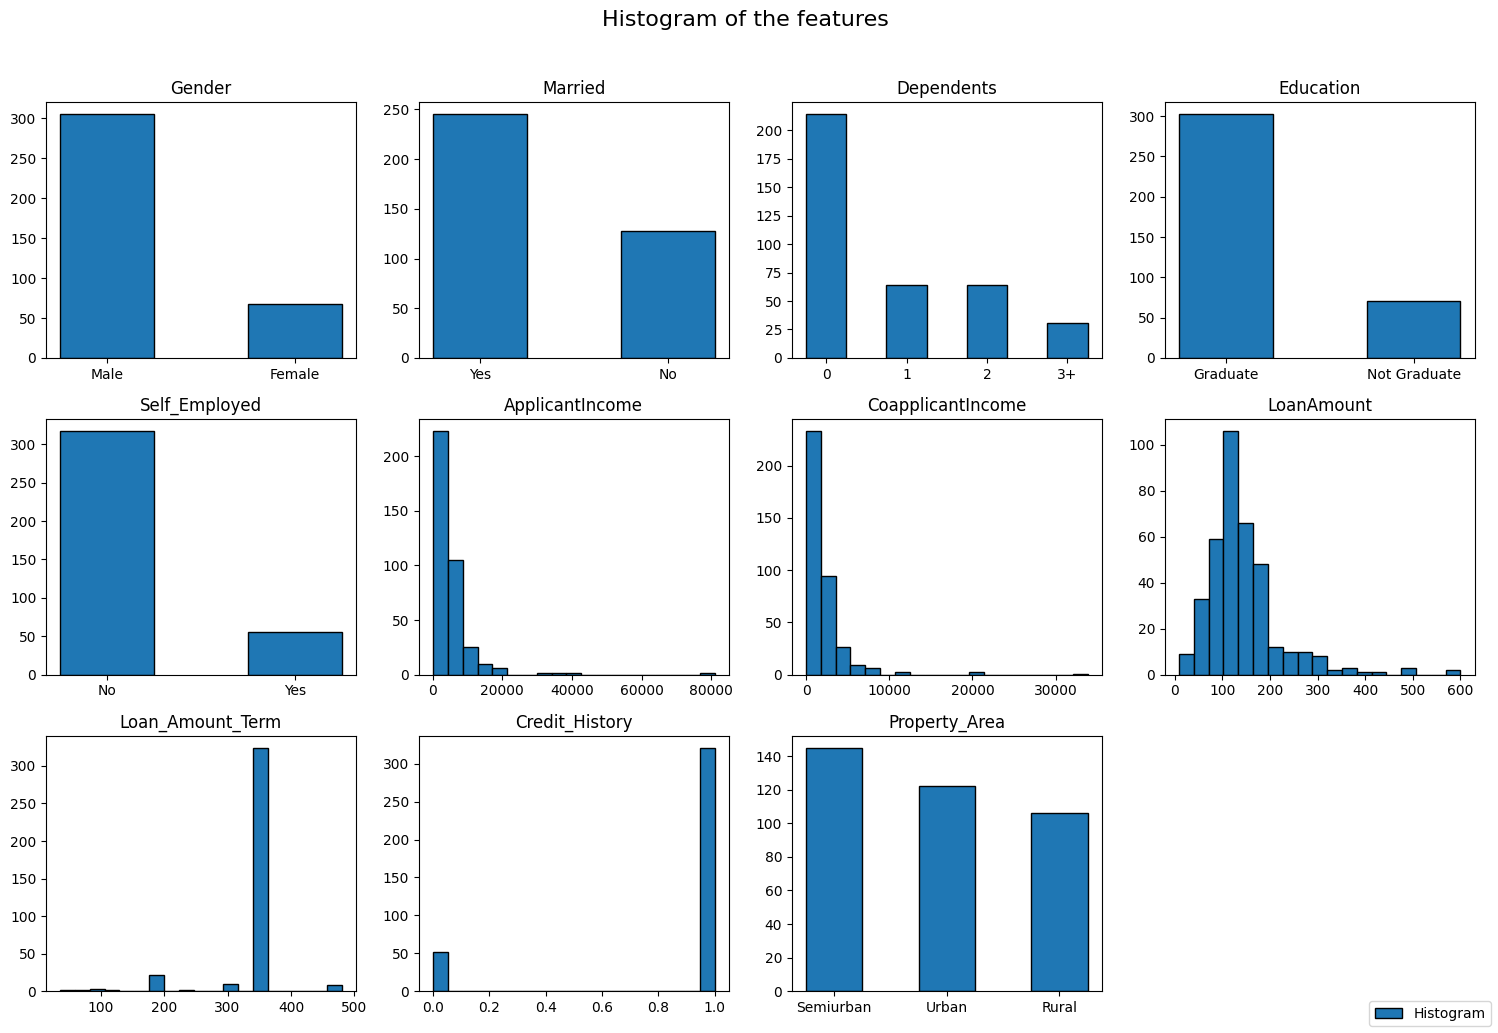

In [9]:
plot_histogram(features)

7. What are the different feature types in this data (e.g, continuous vs categorical).

In [10]:
columns = train_df.columns
continuous_features = []
categorical_features = []

for col in columns:
    if isCategorical(col):
        categorical_features.append(col)
    else:
        continuous_features.append(col)
        print("{}: range [{}, {}]".format(col, train_df[col].min(), train_df[col].max()))
print("=================================================================================")
print("Data Types:", train_df.dtypes)
print("=================================================================================")
print("Categorical Features: {}".format(categorical_features))
print("Continuous Features: {}".format(continuous_features))

ApplicantIncome: range [150, 81000]
CoapplicantIncome: range [0.0, 33837.0]
LoanAmount: range [9.0, 600.0]
Loan_Amount_Term: range [36.0, 480.0]
Credit_History: range [0.0, 1.0]
Data Types: Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object
Categorical Features: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
Continuous Features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In the data, we can see two types of features: Categorical and Continuous.

Here are the Categorical features:
* Gender: Male, Female
* Married: Yes, No
* Dependents: 0, 1, 2, 3+
* Education: Graduate, Not Graduate
* Self_Employed: Yes, No
* Property_Area: Semiurban, Urbanm Rural
* Loan_Status: Y, N

Here are the Continuous features and their corresponding range:
* ApplicantIncome: [150, 81000]
* CoapplicantIncome: [0.0, 33837.0]
* LoanAmount: [9.0, 600.0]
* Loan_Amount_Term: [36.0, 480.0]
* Credit History: [0.0, 1.0]

#### A-2 Implementation

Using the data you pre-processed above, implement a classification tree from scratch for prediction. You are NOT allowed to use machine learning libraries for the tree model. Build the tree model using training data and Gini Index as the splitting criteria. Validate the trained model with the validation data.

Below are the steps you may want to consider.
* Define a splitting criteria: 1) this criteria assigns a score to a split.
* Create the split: 1) split the dataset by iterating over all the rows and feature columns; 2) evaluate all the splits using the splitting criteria; 3) choose the best split.
* Build the tree: 1) decide when to stop growing (when the tree reaches the maximum allowed depth or when a leaf is empty or has only 1 element); 2) split recursively by calling the same splitting function; 3) create a root node and apply recursive splitting.
* Predict with the tree: For a given data point, make a prediction using the tree.

##### Encoder

Since some of our features and the label are categorical data, I created the Encoder class to encode our data from categorical to integers before feeding it into our decision tree model. The mapping is shown below.

In [11]:
class Encoder:
    def __init__(self, features, label):
        self.mapping = {}  
        # features 
        for col in features.columns:
            if isCategorical(col):
                # One-hot encode the categorical features
                categories = features[col].unique()
                self.mapping[col] = {category: i for i, category in enumerate(categories)}
        # label 
        self.mapping[label.name] = {"N": 0, "Y":1}
    def encode(self, data):
        if isinstance(data, pd.Series):
            data = data.apply(lambda x: self.mapping[data.name].get(x, x))
        elif isinstance(data, pd.DataFrame):
            for col in data.columns:
                if isCategorical(col):
                    data.loc[:, col] = data.loc[:, col].apply(lambda x: self.mapping[col].get(x, x))
                    data[col] = data[col].astype(int) 
        return data
    
encoder = Encoder(features, label)
print("Encodings: {}".format(json.dumps(encoder.mapping, indent=4)))

Encodings: {
    "Gender": {
        "Male": 0,
        "Female": 1
    },
    "Married": {
        "Yes": 0,
        "No": 1
    },
    "Dependents": {
        "1": 0,
        "0": 1,
        "2": 2,
        "3+": 3
    },
    "Education": {
        "Graduate": 0,
        "Not Graduate": 1
    },
    "Self_Employed": {
        "No": 0,
        "Yes": 1
    },
    "Property_Area": {
        "Urban": 0,
        "Semiurban": 1,
        "Rural": 2
    },
    "Loan_Status": {
        "N": 0,
        "Y": 1
    }
}


##### Dataset and Dataloader

I split the data into training and testing sets using a train-to-test ratio of 8:2.

In [12]:
class Dataset:
    def __init__(self, features, label, ratio=0.8, encoder=None):
        self.features = features
        self.label = label
        self.encoder = encoder

        self.ratio = ratio
        self.num_samples = features.shape[0]
        self.num_train_samples = int(ratio * self.num_samples)
        self.num_test_samples = self.num_samples - self.num_train_samples
        
        self.train_indices = np.random.choice(self.num_samples, self.num_train_samples, replace=False)
        self.test_indices = np.array([i for i in range(self.num_samples) if i not in self.train_indices])

    
    def get_data(self, is_train=True):
        indices = self.train_indices if is_train else self.test_indices
        features = self.features.iloc[indices].copy()  # Explicitly working on a copy
        label = self.label.iloc[indices]
        
        if self.encoder is not None:
            features = self.encoder.encode(features)
            label = self.encoder.encode(label)

        return features, label

class DataLoader:
    def __init__(self, dataset):
        self.train_loader = dataset.get_data(is_train=True)
        self.test_loader = dataset.get_data(is_train=False)

np.random.seed(10)
dataset = Dataset(features, label, encoder=encoder)
dataloader = DataLoader(dataset)

print("Number of training samples: {}".format(dataset.num_train_samples))
print("Number of test samples: {}".format(dataset.num_test_samples))

train_data, train_label = dataloader.train_loader
val_data, val_label = dataloader.test_loader

Number of training samples: 298
Number of test samples: 75


##### Define the decision tree model

Here, I present the implementation of my decision tree, which comprises two classes: the <b>DecisionTree</b> class and the <b>Node</b> class (encapsulated within the DecisionTree class).

###### Building the tree
Given the data and labels, the <b>Node</b> class calculates the following three values: the <b>Gini index</b>, the <b>best feature</b> to split on, and the corresponding <b>threshold</b>. Below are the equations used to determine these values.

1. Gini Index: The Gini Index measures the impurity of the dataset $D'\subset D$ at a given node, where $D'$  is a subset of the original training data $D$. 

The Gini Index for $D'$ is calculated as:
$$
Gini(D') = 1 - \sum_{y\in Y} (p_y)^2
$$
Here, $Y$ represents the set of all possible labels for the target variable, and $p_y$ is the probability of observing class $y$ in the subset $D'$. The Gini Index is minimized when all records in $D'$ belong to a single class, indicating a pure node.

2. Best split Threshold: The best split treshold should be the threshold $\theta^c_*$ that generates the minimal impurity after the split for feature $c$.

To find the best split threshold, I first find the unique values of that feature ($c$) and sort it. Next, I select the middle points of the unique values as the tresholds that I need to try to split according to. Assume:
$$
X^c = [x^c_1, x^c_2, ..., x^c_k]
$$
, where there are $|X^c|=k$ unique values. Then the set of thresholds $\theta^c$ is

$$
\theta^c = [\theta^c_1, \theta^c_2, ..., \theta^c_{k-1}, \theta^c_k]  = [\frac{x^c_2+x^c_1}{2}, \frac{x^c_3+x^c_2}{2}, ..., \frac{x^c_{k}+x^c_{k-1}}{2}, x^c_k]
$$

if $|X^c|>1$. If $|X^c|=1$, then $\theta$ = [$x^c_1$].

Therefore, the best threshold can be calculated as:

$$
   \theta^c_* = arg\min_{\theta^c} (\frac{|D'_L|}{|D'|}\times Gini(D'_L) + \frac{|D'_R|}{|D'|}\times Gini(D'_R))
$$

where $D'_L = \{D' | x^c\leq \theta\}$ and $D'_R = \{D' | x^c> \theta\}$.

3. Best split feature: We determine the best split feature $c^*$ if $\theta^{c^*}_*$ minimizes the impurity.

After identifying the optimal split feature and the corresponding threshold, we will use these to partition the data $D'$ into two subsets: the left ($D'_L$) and the right ($D'_R$). These steps are then performed recursively and increase the depth until the base case is met.

Base case (when any one of the following conditions is met):
* the depth exceeds max_depth
* the node is pure (i.e. all the data points in the node have the same label)
* the node contains fewer than two data points (cannot split)

###### Predicting
When predicting the label, we traverse down the tree we have built, following the split conditions until we reach a leaf node (where both the left and right children are None). We provide two methods of outputting the label:

1. model.predict(): This method returns the label with the highest occurrence within the leaf node.
2. model.predict_proba(): This method returns the probability of each class, where the probability is defined as:
$$
p_i = \frac{|\{D'| y=i \}|}{|D'|}
$$
Here, $D'$ is the training data in the leaf, and $\{D'| y=i \}$  is the subset of $D'$ that has the label $i$.


In [13]:
class DecisionTree:
    class Node:
        def __init__(self, data, label, depth, classes):
            self.depth = depth
            self.data = data
            self.label = label
            self.classes = classes
            
            self.gini = self.giniIndex(label)
            self.left = None
            self.right = None
            self.value = np.array([np.sum(label == l) for l in classes])
            
            if data.shape[0] > 0:
                self.split, (self.left_data, self.left_label), (self.right_data, self.right_label) = self.splitAttribute(data, label)

        def get_label(self):
            return self.classes[np.argmax(self.value)]
        
        def get_prob(self):
            return self.value/np.sum(self.value)

        def giniIndex(self, label):
            # calculate the gini index
            unique_labels = np.unique(label)
            gini = 1

            for l in unique_labels:
                gini -= (np.sum(label == l) / len(label)) ** 2

            return gini

        # use the gini index as the criterion
        def splitAttribute(self, data, label):
            min_impurity = np.inf   

            best_split = None
            for i in range(data.shape[1]):
                # for each feature, find the best split
                feature = data.iloc[:, i]
     
                unique_values = np.unique(feature)

                if unique_values.shape[0] > 1:
                    unique_values = (unique_values[1:] + unique_values[:-1]) / 2
                    unique_values = np.array(list(unique_values) + [feature.max()])

                for v in unique_values:
                    
                    left_data_indices = np.argwhere(data.iloc[:, i] <= v).flatten()
                    right_data_indices = np.argwhere(data.iloc[:, i] > v).flatten()
                    
                    left_label = label.iloc[left_data_indices]
                    right_label = label.iloc[right_data_indices]

                    left_gini = self.giniIndex(left_label)
                    right_gini = self.giniIndex(right_label)
                    
                    impurity = (left_gini * len(left_label) + right_gini * len(right_label)) / len(label)
                    
                    if impurity < min_impurity:
                        min_impurity = impurity
                        best_split = (i, v)

            # Use boolean indexing for splitting
            split_value = best_split[1]
            left_mask = data.iloc[:, best_split[0]] <= split_value
            right_mask = ~left_mask

            left_data = data[left_mask]
            right_data = data[right_mask]
            left_label = label[left_mask]
            right_label = label[right_mask]

            return best_split, (left_data, left_label), (right_data, right_label)
        
        def __str__(self):
            if self.left is None and self.right is None:
                return "Node: depth={}, gini={:.3f}, samples={}, value=[{},{}]".format(self.depth, self.gini, self.label.shape[0], self.value[0], self.value[1])
            else:
                splitAttr = self.split[0]
                splitThreshold = self.split[1]
                return "Node: depth={}, x[{}]<={}, gini={:.3f}, samples={}, value=[{},{}]".format(self.depth, splitAttr, splitThreshold, self.gini, self.label.shape[0], self.value[0], self.value[1])

    def __init__(self, max_depth=None):
        self.max_depth = max_depth 
        self.tree = None


    def generateTree(self, data, label, depth):
        node = self.Node(data, label, depth, self.classes)
        
        if (self.max_depth is not None and depth >= self.max_depth) or data.shape[0] < 2 or np.unique(label).shape[0] == 1:
            return node

        node.left = self.generateTree(node.left_data, node.left_label, depth + 1)
        node.right = self.generateTree(node.right_data, node.right_label, depth + 1)

        return node

    def fit(self, X, y):        
        self.classes = np.unique(y)
        self.root = self.generateTree(X, y, 0)
    
    def plot_tree(self):
        self.__plot__(self.root)

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            y_pred.append(self.__predict__(self.root, X.iloc[i]))
        y_pred = np.array(y_pred)
        return y_pred
    
    def predict_proba(self, X):
        y_pred_prob = []
        for i in range(X.shape[0]):
            y_pred_prob.append(self.__predict__(self.root, X.iloc[i], probability=True))
        y_pred_prob = np.array(y_pred_prob) 
        return y_pred_prob

    def __plot__(self, node):
        if node is not None:
            print(node)
            self.__plot__(node.left)
            self.__plot__(node.right)

    def __predict__(self, node, X, probability=False):
        if node.left is None and node.right is None:
            if probability:
                return node.get_prob()
            else:
                return node.get_label()
        if X[node.split[0]] <= node.split[1]:
            return self.__predict__(node.left, X, probability)
        else:
            return self.__predict__(node.right, X, probability)


In [14]:
def evaluate(y, y_pred, verbose=False):
    accuracy = np.sum(y_pred == y) / len(y)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    if verbose:
        print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}".format(accuracy, precision, recall, f1))
    return accuracy, precision, recall, f1

##### Train the decision tree

In [15]:
max_depth = 3
clf = DecisionTree(max_depth=max_depth)
clf.fit(train_data, train_label)
clf.plot_tree()


Node: depth=0, x[9]<=0.5, gini=0.437, samples=298, value=[96,202]
Node: depth=1, x[5]<=4316.5, gini=0.139, samples=40, value=[37,3]
Node: depth=2, gini=0.000, samples=27, value=[27,0]
Node: depth=2, x[5]<=5392.5, gini=0.355, samples=13, value=[10,3]
Node: depth=3, gini=0.480, samples=5, value=[2,3]
Node: depth=3, gini=0.000, samples=8, value=[8,0]
Node: depth=1, x[8]<=420.0, gini=0.353, samples=258, value=[59,199]
Node: depth=2, x[10]<=1.5, gini=0.340, samples=253, value=[55,198]
Node: depth=3, gini=0.284, samples=187, value=[32,155]
Node: depth=3, gini=0.454, samples=66, value=[23,43]
Node: depth=2, x[5]<=1572.5, gini=0.320, samples=5, value=[4,1]
Node: depth=3, gini=0.000, samples=1, value=[0,1]
Node: depth=3, gini=0.000, samples=4, value=[4,0]


##### Validate the model

In this section, we present the model's performance on the validation set, accompanied by the ROC curve for a comprehensive evaluation.

Accuracy: 0.840, Precision: 0.828, Recall: 0.981, F1 score: 0.898


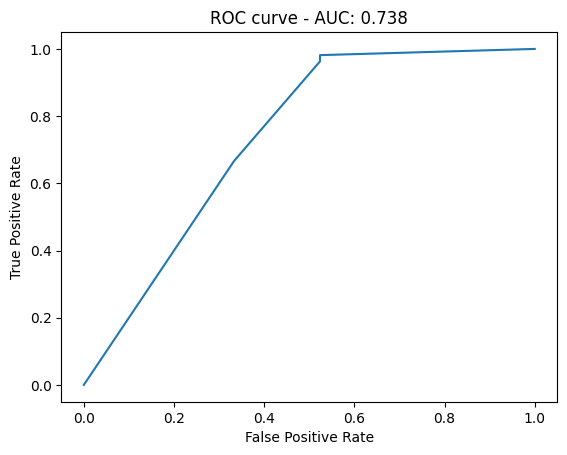

In [16]:
y_pred = clf.predict(val_data)
_ = evaluate(val_label, y_pred, verbose=True)

y_pred_prob = clf.predict_proba(val_data)[:, 1]
fpr, tpr, thresholds = roc_curve(val_label, y_pred_prob)
auc = roc_auc_score(val_label, y_pred_prob)
# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - AUC: {:.3f}'.format(auc))
plt.show()


##### Verify the result with sklearn

Here, I utilize the DecisionTreeClassifier from scikit-learn to verify my implementation with its performance.

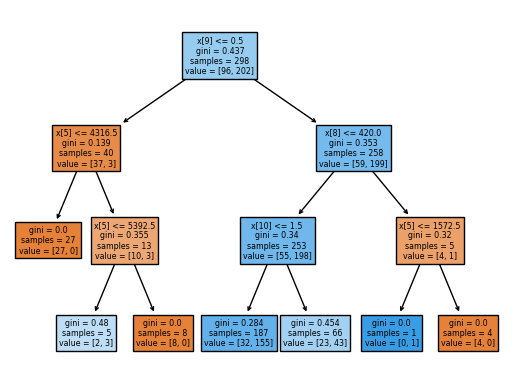

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf_sklearn = DecisionTreeClassifier(max_depth=max_depth)
clf_sklearn.fit(train_data, train_label)
# Visualize the decision tree
_ = tree.plot_tree(clf_sklearn, filled=True)


Accuracy: 0.840, Precision: 0.828, Recall: 0.981, F1 score: 0.898


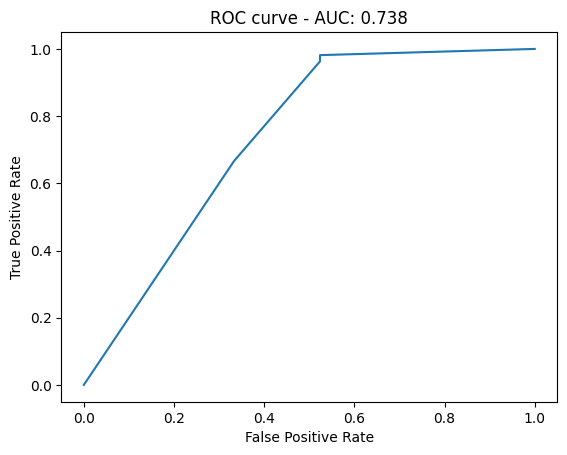

The prediction result between our implementation and scikit-learn's
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        64

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [18]:
#Predict the response for test dataset
y_pred_sklearn = clf_sklearn.predict(val_data)
_ = evaluate(val_label, y_pred_sklearn, verbose=True)

y_pred_sklearn_prob = clf_sklearn.predict_proba(val_data)[:, 1]
fpr, tpr, thresholds = roc_curve(val_label, y_pred_sklearn_prob)
auc = roc_auc_score(val_label, y_pred_sklearn_prob)
# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - AUC: {:.3f}'.format(auc))
plt.show()

# calculate the precision, recall, and f1-score between the predicted label from the sklearn model and my model
from sklearn.metrics import classification_report
print("=================================================================================")
print("The prediction result between our implementation and scikit-learn's")
print(classification_report(y_pred, y_pred_sklearn))

##### Hyperparameter tuning

Here, we attempt to find the optimal hyperparameter for our decision tree model, which in this case is max_depth. I also use 5-fold cross-validation to ensure the model's stability and to mitigate the potential for overfitting, thereby improving the reliability of the hyperparameter performance assessment.


In [19]:
def train_DecisionTree(train_data, train_label, num_folds=5, verbose=True):
    max_depths = [3, 5, 7, 10, None]
    result = {}
    fold_size = train_data.shape[0] // num_folds

    for max_depth in max_depths:
        print("Training with max depth={}".format(max_depth))
        # k-fold cross-validation
        aucs = []
        for i in range(num_folds):
            if verbose:
                print("Fold: ", i)
            val_indices = np.arange(i * fold_size, (i + 1) * fold_size)
            train_indices = np.array([j for j in range(train_data.shape[0]) if j not in val_indices])

            _val_data = train_data.iloc[val_indices]
            _val_label = train_label.iloc[val_indices]

            _train_data = train_data.iloc[train_indices]
            _train_label = train_label.iloc[train_indices]

            model = DecisionTree(max_depth=max_depth)
            model.fit(_train_data, _train_label)

            y_pred = model.predict(_val_data)
            auc = roc_auc_score(_val_label, y_pred)
            accuracy = np.sum(y_pred == _val_label) / len(_val_label)
            precision = precision_score(_val_label, y_pred)
            recall = recall_score(_val_label, y_pred)
            f1 = f1_score(_val_label, y_pred)
            aucs.append(auc)
            if verbose:
                print(" - AUC: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}".format(auc, accuracy, precision, recall, f1))
        aucs = np.array(aucs)
        print("- average AUC: {:.3f}".format(aucs.mean()))
        print("=================================================================================")
        result[max_depth] = aucs.mean()

    return result

In [20]:
result = train_DecisionTree(train_data, train_label)

Training with max depth=3
Fold:  0
 - AUC: 0.587, Accuracy: 0.712, Precision: 0.704, Recall: 0.974, F1 score: 0.817
Fold:  1
 - AUC: 0.724, Accuracy: 0.814, Precision: 0.796, Recall: 0.975, F1 score: 0.876
Fold:  2
 - AUC: 0.655, Accuracy: 0.729, Precision: 0.714, Recall: 0.946, F1 score: 0.814
Fold:  3
 - AUC: 0.633, Accuracy: 0.780, Precision: 0.804, Recall: 0.932, F1 score: 0.863
Fold:  4
 - AUC: 0.699, Accuracy: 0.780, Precision: 0.787, Recall: 0.925, F1 score: 0.851
- average AUC: 0.660
Training with max depth=5
Fold:  0
 - AUC: 0.587, Accuracy: 0.712, Precision: 0.704, Recall: 0.974, F1 score: 0.817
Fold:  1
 - AUC: 0.699, Accuracy: 0.780, Precision: 0.787, Recall: 0.925, F1 score: 0.851
Fold:  2
 - AUC: 0.660, Accuracy: 0.712, Precision: 0.727, Recall: 0.865, F1 score: 0.790
Fold:  3
 - AUC: 0.609, Accuracy: 0.712, Precision: 0.800, Recall: 0.818, F1 score: 0.809
Fold:  4
 - AUC: 0.726, Accuracy: 0.797, Precision: 0.804, Recall: 0.925, F1 score: 0.860
- average AUC: 0.656
Traini

In [21]:
best_max_depth = max(result, key=result.get)
print("Best max_depth: ", best_max_depth, "AUC: ", result[best_max_depth])

Best max_depth:  7 AUC:  0.6758751786383366


From the results, we can see that greater depth does not necessarily produce a better AUC. This is because having more depth may lead to overfitting in the tree model.

Use the best max_depth to train the model and verify the performance with the validation set.

In [22]:
decision_tree_model = DecisionTree(max_depth=best_max_depth)
decision_tree_model.fit(train_data, train_label)

y_pred = decision_tree_model.predict(val_data)
_ = evaluate(val_label, y_pred, verbose=True)

Accuracy: 0.827, Precision: 0.847, Recall: 0.926, F1 score: 0.885


##### Inference on test data

Using the trained model, conduct inference on the test data and save the predicted result in a separate file called FirstName LastName preds.csv with the column name pred tree.

Since there exists null data in the test set, I remove those rows that contains null data in the preprocessing section for test set as well. 

In [23]:
test_data = test_df[feature_columns].copy()
test_data = encoder.encode(test_data)

y_pred = decision_tree_model.predict(test_data)
# convert the label back to the original format
y_pred = ["Y" if y == 1 else "N" for y in y_pred]

if not os.path.exists(out_path):
    print("Creating a new predictions dataframe")
    predictions_df = pd.DataFrame(columns=["pred_tree", "pred_xgboost"])
else:
    print("Reading the existing predictions from: {}".format(out_path))
    predictions_df = pd.read_csv(out_path)

predictions_df["pred_tree"] = y_pred
print(predictions_df.head(n=5))

print("Saving the predictions to: {}".format(out_path))
predictions_df.to_csv(out_path, index=False)


Reading the existing predictions from: ./Mu-Ruei_Tseng_preds.csv
  pred_tree pred_xgboost
0         Y            Y
1         Y            Y
2         Y            Y
3         N            N
4         Y            Y
Saving the predictions to: ./Mu-Ruei_Tseng_preds.csv


### Part B - Boosting (30 points)

Now that we implemented classification trees in part A, we would like to use a decision tree-based ensemble Machine Learning algorithm for Loan Dataset. You can use the same pre-processed dataset as part A.


1. Define a function train_XGBoost to use an XGBoost model with L2 regularization that returns a dictionary. The keys of the returned dictionary would be the lambda parameter (for L2 regularization) and the corresponding value is the mean AUC of 10 fold cross validation. Use the following lambda parameters: [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]. Describe the process of finding the optimal lambda value for l2 regularization.

In order to find the optimal lambda value for L2 regularization, I iterate through all the lambda parameters I want to test and perform 10-fold cross-validation to calculate the average AUC. The optimal parameter is chosen based on the highest AUC score among all the parameters.

In [24]:
def train_XGBoost(train_data, train_label, verbose=True):
    
    lambda_params = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    result = {}
    num_folds = 10
    fold_size = train_data.shape[0] // num_folds

    for lambda_param in lambda_params:
        print("Training with lambda={}".format(lambda_param))
        # 10-fold cross-validation
        aucs = []
        for i in range(num_folds):
            if verbose:
                print("Fold: ", i)
            val_indices = np.arange(i * fold_size, (i + 1) * fold_size)
            train_indices = np.array([j for j in range(train_data.shape[0]) if j not in val_indices])

            _val_data = train_data.iloc[val_indices]
            _val_label = train_label.iloc[val_indices]

            _train_data = train_data.iloc[train_indices]
            _train_label = train_label.iloc[train_indices]

            model = xgboost.XGBClassifier(reg_lambda=lambda_param)
            model.fit(_train_data, _train_label)

            y_pred = model.predict(_val_data)
            auc = roc_auc_score(_val_label, y_pred)
            accuracy = np.sum(y_pred == _val_label) / len(_val_label)
            precision = precision_score(_val_label, y_pred)
            recall = recall_score(_val_label, y_pred)
            f1 = f1_score(_val_label, y_pred)
            aucs.append(auc)
            if verbose:
                print(" - AUC: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}".format(auc, accuracy, precision, recall, f1))
        aucs = np.array(aucs)
        print("- average AUC: {:.3f}".format(aucs.mean()))
        print("=================================================================================")
        result[lambda_param] = aucs.mean()

    return result
    

In [25]:
result = train_XGBoost(train_data, train_label, verbose=False)

Training with lambda=0.001
- average AUC: 0.645
Training with lambda=0.01
- average AUC: 0.632
Training with lambda=0.1
- average AUC: 0.622
Training with lambda=1
- average AUC: 0.641
Training with lambda=10.0
- average AUC: 0.639
Training with lambda=100.0
- average AUC: 0.674
Training with lambda=1000.0
- average AUC: 0.500


In [26]:
best_lambda = max(result, key=result.get)
print("Best lambda: ", best_lambda, "AUC: ", result[best_lambda])

Best lambda:  100.0 AUC:  0.67365163130643


2. Train and test the model with the best parameters you found.

Given the best lambda value identified in the previous section, we can tune other hyperparameters using a similar approach to that used for finding the optimal lambda value. In this section, we attempt to find the best values for n_estimators and max_depth.

In [27]:
def find_hyperparam_XGBoost(train_data, train_label, best_lambda, verbose=True):
    n_estimators = [50, 100, 300, 1000, None]
    max_depths = [3, 5, 7, 10, None]
    lambda_param = best_lambda
    num_folds = 10
    fold_size = train_data.shape[0] // num_folds
    
    result = {}
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            print("Training with n_estimators={}, max_depth={}".format(n_estimator, max_depth))
            
            aucs = []
            for i in range(num_folds):
                if verbose:
                    print("Fold: ", i)
                val_indices = np.arange(i * fold_size, (i + 1) * fold_size)
                train_indices = np.array([j for j in range(train_data.shape[0]) if j not in val_indices])

                _val_data = train_data.iloc[val_indices]
                _val_label = train_label.iloc[val_indices]

                _train_data = train_data.iloc[train_indices]
                _train_label = train_label.iloc[train_indices]

                model = xgboost.XGBClassifier(reg_lambda=lambda_param, n_estimators=n_estimator, max_depth=max_depth)
                model.fit(_train_data, _train_label)

                y_pred = model.predict(_val_data)
                auc = roc_auc_score(_val_label, y_pred)
                accuracy = np.sum(y_pred == _val_label) / len(_val_label)
                precision = precision_score(_val_label, y_pred)
                recall = recall_score(_val_label, y_pred)
                f1 = f1_score(_val_label, y_pred)
                aucs.append(auc)
                if verbose:
                    print(" - AUC: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}".format(auc, accuracy, precision, recall, f1))
                    
            aucs = np.array(aucs)
            print("- average AUC: {:.3f}".format(aucs.mean()))
            print("=================================================================================")
            result[(n_estimator, max_depth, best_lambda)] = aucs.mean()

    return result
    

In [28]:
hyper_param_result = find_hyperparam_XGBoost(train_data, train_label, best_lambda,verbose=False)

Training with n_estimators=50, max_depth=3
- average AUC: 0.680
Training with n_estimators=50, max_depth=5
- average AUC: 0.677
Training with n_estimators=50, max_depth=7
- average AUC: 0.675
Training with n_estimators=50, max_depth=10
- average AUC: 0.675
Training with n_estimators=50, max_depth=None
- average AUC: 0.675
Training with n_estimators=100, max_depth=3
- average AUC: 0.684
Training with n_estimators=100, max_depth=5
- average AUC: 0.674
Training with n_estimators=100, max_depth=7
- average AUC: 0.673
Training with n_estimators=100, max_depth=10
- average AUC: 0.673
Training with n_estimators=100, max_depth=None
- average AUC: 0.674
Training with n_estimators=300, max_depth=3
- average AUC: 0.657
Training with n_estimators=300, max_depth=5
- average AUC: 0.658
Training with n_estimators=300, max_depth=7
- average AUC: 0.661
Training with n_estimators=300, max_depth=10
- average AUC: 0.653
Training with n_estimators=300, max_depth=None
- average AUC: 0.651
Training with n_es

Show the best hyperparameters

In [29]:
best_hyper_param = None
max_auc = 0
for hyper_param, auc in hyper_param_result.items():
    if max_auc < auc:
        max_auc = auc
        best_hyper_param = hyper_param
print("Best hyperparameters: ", best_hyper_param, "AUC: ", hyper_param_result[best_hyper_param])

Best hyperparameters:  (100, 3, 100.0) AUC:  0.6836274398116504


Test the result on the validation set

In [30]:
(best_n_estimators, best_max_depth, best_lambda) = best_hyper_param
xgboost_model = xgboost.XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, reg_lambda=best_lambda)
xgboost_model.fit(train_data, train_label)

y_pred_prob = xgboost_model.predict_proba(val_data)[:, 1]
fpr, tpr, thresholds = roc_curve(val_label, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred = np.where(y_pred_prob > optimal_threshold, 1, 0)
auc = roc_auc_score(val_label, y_pred)

_ = evaluate(val_label, y_pred, verbose=True)
print("AUC: {:.3f}".format(auc))

Accuracy: 0.787, Precision: 0.852, Recall: 0.852, F1 score: 0.852
AUC: 0.735


3. Plot the ROC curve for the XGBoost model on validation data and also print the area under the curve. Include axes labels, legend, and title in the Plot.

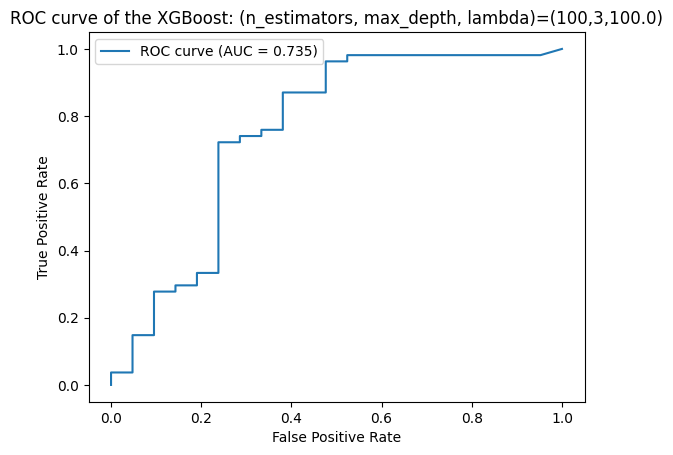

In [31]:
# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of the XGBoost: (n_estimators, max_depth, lambda)=({},{},{})'.format(best_n_estimators, best_max_depth, best_lambda))
plt.legend()
plt.show()

Compare the validation result you obtained using XGBoost with the results using the tree you implemented in part A. Which model did perform better and why?

Observing from the AUC curve and the accuracy, precision, recall, and F1 score, there isn't much difference between the Decision Tree model and XGBoost. One possible reason is that the dataset provided is relatively simple and a single decision tree can already capture the underlying correlation between the features; therefore, there isn't much of an improvement when using a more complex model like XGBoost. Furthermore, we can also observe that the best depth between XGBoost and simple Decision Tree model may differ as XGBoost is designed to combine multiple shallow trees, whereas a single Decision Tree model might require greater depth to achieve optimal performance on its own.

Decision Tree:
Accuracy: 0.827, Precision: 0.847, Recall: 0.926, F1 score: 0.885
XGBoost:
Accuracy: 0.840, Precision: 0.839, Recall: 0.963, F1 score: 0.897


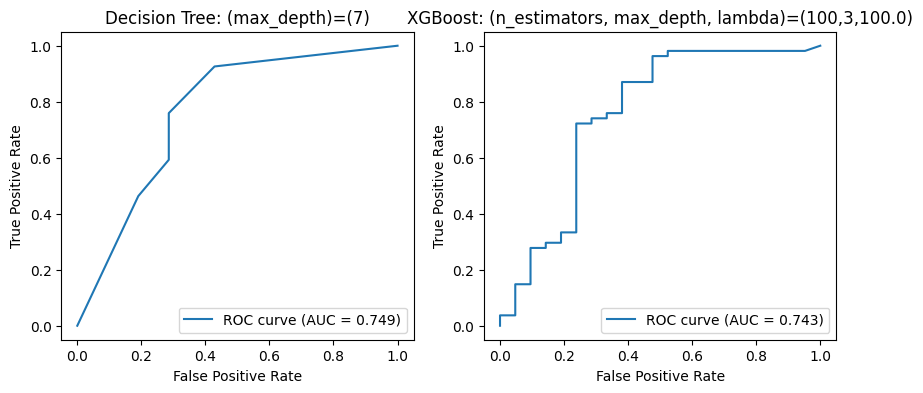

In [32]:
y_pred_prob_decision_tree = decision_tree_model.predict_proba(val_data)[:, 1]
y_pred_decision_tree = decision_tree_model.predict(val_data)
decision_tree_fpr, decision_tree_tpr, decision_tree_thresholds = roc_curve(val_label, y_pred_prob_decision_tree)
decision_tree_auc = roc_auc_score(val_label, y_pred_decision_tree)
print("Decision Tree:")
_ = evaluate(val_label, y_pred_decision_tree, verbose=True)

y_pred_prob_xgboost = xgboost_model.predict_proba(val_data)[:, 1]
y_pred_xgboost = xgboost_model.predict(val_data)
xgboost_fpr, xgboost_tpr, xgboost_thresholds = roc_curve(val_label, y_pred_prob_xgboost)
print("XGBoost:")
xgboost_auc = roc_auc_score(val_label, y_pred_xgboost)
_ = evaluate(val_label, y_pred_xgboost, verbose=True)
print("=================================================================================")


fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(decision_tree_fpr, decision_tree_tpr, label='ROC curve (AUC = %0.3f)' % decision_tree_auc)
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='Decision Tree: (max_depth)=({})'.format(decision_tree_model.max_depth))
axes[0].legend()

axes[1].plot(xgboost_fpr, xgboost_tpr, label='ROC curve (AUC = %0.3f)' % xgboost_auc)
axes[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='XGBoost: (n_estimators, max_depth, lambda)=({},{},{})'.format(xgboost_model.n_estimators, xgboost_model.max_depth, xgboost_model.reg_lambda))
axes[1].legend()

plt.show()

##### Inference on test data

Using the trained model, conduct inference on the test data and save the predicted result into the predictions csv file with pred xgboost as the column name.

Since there exists null data in the test set, I remove those rows that contains null data in the preprocessing section for test set as well. 

In [33]:
y_pred = xgboost_model.predict(test_data)
# convert the label back to the original format
y_pred = ["Y" if y == 1 else "N" for y in y_pred]

if not os.path.exists(out_path):
    print("Creating a new predictions dataframe")
    predictions_df = pd.DataFrame(columns=["pred_tree", "pred_xgboost"])
else:
    print("Reading the existing predictions from: {}".format(out_path))
    predictions_df = pd.read_csv(out_path)

predictions_df["pred_xgboost"] = y_pred
print(predictions_df.head(n=5))

print("Saving the predictions to: {}".format(out_path))
predictions_df.to_csv(out_path, index=False)


Reading the existing predictions from: ./Mu-Ruei_Tseng_preds.csv
  pred_tree pred_xgboost
0         Y            Y
1         Y            Y
2         Y            Y
3         N            N
4         Y            Y
Saving the predictions to: ./Mu-Ruei_Tseng_preds.csv
